In [61]:
import numpy as np
import ggseg
import pickle

from matplotlib import pyplot as plt 
import pandas as pd 
import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go
import plotly.offline as pyo

import json

In [62]:
import os, glob
from PIL import Image

### LOAD FILE

In [63]:
read_input_file = open('data/EDADS_subtype_timelines_agecorrected_opt.pickle','rb')
load_inputs = pickle.load(read_input_file)
read_input_file.close()

T, S, Sboot = load_inputs

/Users/macos/opt/anaconda3/envs/umc/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator MinCovDet from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations



# Separate Subcortical & Cortical Regions

### Load mappings

In [64]:
f = open('data/DK_2D_combined.json')
map_dk = json.load(f)
f.close()

f = open('data/ASEG_combined.json')
map_aseg = json.load(f)
f.close()

## Get labeles

In [65]:
def get_labels(S):
    unique_subtypes = np.unique(S['subtypes'][~np.isnan(S['subtypes'])])
    subtype_labels = []
    for i in range(len(unique_subtypes)):
        subtype_labels.append('Subtype '+str(int(unique_subtypes[i])))        
    return subtype_labels

In [66]:
labels = get_labels(S)
labels

['Subtype 0', 'Subtype 1', 'Subtype 2', 'Subtype 3']

### Map DK

Map values from larger regions to each small region included

In [67]:
def dk_dict(T,S, mapped_dict, subtype_labels = None, subtype = None):
    
    """
    Creates a dictionary, which can be used as input to ggseg.plot_dk() function
    :param T: dataframe from dk_dataframe() function
    :param S: chosen subtype
    :param mapped_dict: a dictionary with key: values --> T.biomarker_labels: list(DK-labels)
    :param subtype: name or index of the subtype from subtype_lables (optional, choses first available subtype as default)  
    :param subtype_labels: a list with names of the subtypes (optional)
    :return: dictionary with scores for each DK region for chosen subtype
    """
    
    unique_subtypes = np.unique(S['subtypes'][~np.isnan(S['subtypes'])])
    if subtype_labels is None:
        subtype_labels = {f'Subtype {i}': i for i in range(len(unique_subtypes))}
        if subtype is None:
            subtype = next(iter(subtype_labels))
    elif subtype is None:
        subtype = subtype_labels[0]  
               
    # clean names from capital letters
    labels = list(map(lambda x: x.lower(), T.biomarker_labels))
    labels_dict = {num: label.lower() for num, label in enumerate(labels)}
    
    # order the regions
    order = T.sequence_model['ordering'][subtype_labels[subtype]]   
    labels_ordered = []
    for o in order:
        labels_ordered.append(labels_dict[o])   
    
    # get event centers for all regions
    dic = dict(zip(labels_ordered, T.sequence_model['event_centers'][subtype_labels[subtype]]))
                    
    # flat list of dict values (single list of DK-labels)
    dk_flat = [x for v in mapped_dict.values() for x in v]
                
    #Match T.biomarker_labels to DK labels
    list_plot = list()
    for key in mapped_dict.keys():
            for item in mapped_dict[key]:
                list_plot.append(dic[key])
                    
    # Dict for dk-label: T.label value
    dic_dk = dict(zip(dk_flat, list_plot))
    
    return dic_dk

In [68]:
def aseg_dict(T, S, mapped_dict, subtype_labels = None, subtype = None, hemi = False):
    
    """
    Creates a dictionary, which can be used as input to ggseg.plot_dk() function
    :param T: Timeline object
    :param S: subtyping dictionary, subtypes for each patient individually
    :param mapped_dict: a dictionary with key: values --> T.biomarker_labels: list(DK-labels)
    :param subtype_labels: a list with names of the subtypes (optional)
    :param subtype: name or index of the subtype from subtype_lables (optional, choses first available subtype as default)  
    :return: dictionary with scores for each DK region for chosen subtype
    """

    unique_subtypes = np.unique(S['subtypes'][~np.isnan(S['subtypes'])])
    if subtype_labels is None:
        subtype_labels = {f'Subtype {i}': i for i in range(len(unique_subtypes))}
        if subtype is None:
            subtype = next(iter(subtype_labels))
    elif subtype is None:
        subtype = subtype_labels[0]
    
    # clean names from capital letters
    labels = T.biomarker_labels
    labels_dict = {num: label.lower() for num, label in enumerate(labels)}
    order = T.sequence_model['ordering'][subtype_labels[subtype]]
    
    # order the regions
    labels_ordered = []
    for o in order:
        labels_ordered.append(labels_dict[o])    
     
    # Dictionary with all labels
    dic = dict(zip(labels_ordered, T.sequence_model['event_centers'][subtype_labels[subtype]]))
    
    # flat list of dict values (single list of DK-labels)
    aseg_flat = [x for v in mapped_dict.values() for x in v]
            
    #Match T.biomarker_labels to DK labels
    list_plot = list()
    for key in mapped_dict.keys():
        for item in mapped_dict[key]:
            list_plot.append(dic[key])
            
    # Dict for dk-label: T.label value
    dic_aseg = dict(zip(aseg_flat, list_plot))    
        
    return dic_aseg

## Custom function for saving

In [69]:
# Customized function to save plt

def custom_dk(data, cmap='Spectral', background='k', edgecolor='w', ylabel='',
             figsize=(15, 15), bordercolor='w', vminmax=[], title='',
             fontsize=15, filename="file"):
    
    import ggseg
    import matplotlib.pyplot as plt
    import os.path as op
    from glob import glob
    from ggseg import _create_figure_, _render_regions_, _get_cmap_, _render_data_, _add_colorbar_

    wd = op.join(op.dirname(ggseg.__file__), 'data', 'dk')

    # A figure is created by the joint dimensions of the whole-brain outlines
    whole_reg = ['lateral_left', 'medial_left', 'lateral_right',
                 'medial_right']
    files = [open(op.join(wd, e)).read() for e in whole_reg]
    ax = _create_figure_(files, figsize, background, title, fontsize, edgecolor)

    # Each region is outlined
    reg = glob(op.join(wd, '*'))
    files = [open(e).read() for e in reg]
    _render_regions_(files, ax, bordercolor, edgecolor)

    # For every region with a provided value, we draw a patch with the color
    # matching the normalized scale
    cmap, norm = _get_cmap_(cmap, data.values(), vminmax=vminmax)
    _render_data_(data, wd, cmap, norm, ax, edgecolor)

    # DKT regions with no provided values are rendered in gray
    data_regions = list(data.keys())
    dkt_regions = [op.splitext(op.basename(e))[0] for e in reg]
    NA = set(dkt_regions).difference(data_regions).difference(whole_reg)
    files = [open(op.join(wd, e)).read() for e in NA]
    _render_regions_(files, ax, 'gray', edgecolor)

    # A colorbar is added
    _add_colorbar_(ax, cmap, norm, edgecolor, fontsize*0.75, ylabel)

    plt.savefig(f'temp_folder/snapshots/{filename}.png', bbox_inches='tight', pad_inches=0.20)
    plt.close()
    

In [70]:
def custom_aseg(data, cmap='Spectral', background='k', edgecolor='w', ylabel='',
              figsize=(15, 5), bordercolor='w', vminmax=[],
              title='', fontsize=15, filename=""):
    import matplotlib.pyplot as plt
    import os.path as op
    from glob import glob
    import ggseg
    from ggseg import _create_figure_, _render_regions_, _get_cmap_, _render_data_, _add_colorbar_

    wd = op.join(op.dirname(ggseg.__file__), 'data', 'aseg')
    reg = [op.basename(e) for e in glob(op.join(wd, '*'))]

    # Select data from known regions (prevents colorbar from going wild)
    known_values = []
    for k, v in data.items():
        if k in reg:
            known_values.append(v)

    whole_reg = ['Coronal', 'Sagittal']
    files = [open(op.join(wd, e)).read() for e in whole_reg]

    # A figure is created by the joint dimensions of the whole-brain outlines
    ax = _create_figure_(files, figsize, background,  title, fontsize, edgecolor)

    # Each region is outlined
    reg = glob(op.join(wd, '*'))
    files = [open(e).read() for e in reg]
    _render_regions_(files, ax, bordercolor, edgecolor)

    # For every region with a provided value, we draw a patch with the color
    # matching the normalized scale
    cmap, norm = _get_cmap_(cmap, known_values, vminmax=vminmax)
    _render_data_(data, wd, cmap, norm, ax, edgecolor)

    # The following regions are ignored/displayed in gray
    NA = ['Cerebellum-Cortex', 'Cerebellum-White-Matter', 'Brain-Stem']
    files = [open(op.join(wd, e)).read() for e in NA]
    _render_regions_(files, ax, '#111111', edgecolor)

    # A colorbar is added
    _add_colorbar_(ax, cmap, norm, edgecolor, fontsize*0.75, ylabel)

    plt.savefig(f'temp_folder/snapshots/{filename}.png', bbox_inches='tight', pad_inches=0.2)
    plt.close()

## Separate plots - for Streamlit App, with Slider

In [71]:
def plot_dk_atlas(T,S, map_dk, subtype_labels = None, subtype = None, slider = None, save = False, filename='file'):     

    """
    Creates a dictionary, which can be used as input to ggseg.plot_dk() and plots it
    :param T: Timeline object
    :param S: subtyping dictionary, subtypes for each patient individually
    :param subtype_labels: a list with names of the subtypes (optional)
    :param subtype: name or index of the subtype to visualise (optional)  
    :param slider: int (optional)
    :returns a figures by plt.show() -> ggseg.plot_dk() 
    """   
    
    if slider is None:
        dk = dk_dict(T, S, mapped_dict = map_dk, subtype = subtype)  
    else:
        dk_ = dk_dict(T, S, mapped_dict = map_dk, subtype = subtype)
        dk = {k: v for k, v in dk_.items() if v <= slider}
    

    
    if subtype is None:
        # subtype = 'default = 0'
        pass
    
    # save the images for animation
    elif save is True:
                
        custom_dk(dk, cmap='Reds_r', figsize=(6,6),
                  vminmax = [0,1],
                  background='black', edgecolor='white', bordercolor='gray', title=f'Subtype 0',fontsize = 24,
                 filename=filename)          
    
    else:
         ggseg.plot_dk(dk, cmap='Reds_r', figsize=(6,6),
              vminmax = [0,1],
              background='black', edgecolor='white', bordercolor='gray', 
                title=f'{subtype}',fontsize = 24)



def plot_aseg_atlas(T,S, map_aseg, subtype_labels = None, subtype = None, slider = None, save = False, filename='file'):     

    """
    Creates a dictionary, which can be used as input to ggseg.plot_aseg() function
    :param T: Timeline object
    :param S: subtyping dictionary, subtypes for each patient individually
    :param subtype_labels: a list with names of the subtypes (optional)
    :param subtype: name or index of the subtype to visualise (optional)  
    :param slider: int (optional)
    :returns a figures by plt.show() -> ggseg.plot_aseg()
    """
    if slider is None:  
        aseg = aseg_dict(T,S, map_aseg,subtype = subtype)
    else:
        aseg_ = aseg_dict(T,S, map_aseg, subtype = subtype)
        aseg = {k: v for k, v in aseg_.items() if v <= slider}

    if subtype is None:
        # subtype = 'Subtype 0'
        pass 
    
    elif save is True:
        
        custom_aseg(aseg, cmap='Reds_r', figsize=(6,6),
                  vminmax = [0,1],
                  background='black', edgecolor='white', bordercolor='gray', title=f'Subtype 0',fontsize = 20,
                 filename=filename)      
        
    else:
        ggseg.plot_aseg(aseg, cmap='Reds_r', figsize=(6,6),
                vminmax = [0,1],
                background='black', edgecolor='white', bordercolor='gray', title=f'{subtype}', fontsize = 18)

## NEW FILE

In [72]:
# 1. Map to DK-labels
dk_0_new = dk_dict(T, S, mapped_dict = map_dk, subtype='Subtype 0')
# dk_0_new

In [73]:
# 2. Map to ASEG-labels
aseg_0_new = aseg_dict(T,S, mapped_dict = map_aseg,subtype='Subtype 0')
# aseg_0_new

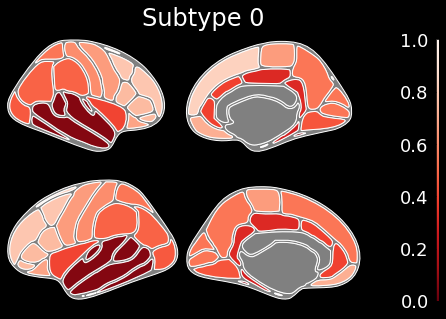

In [74]:
# 3. Plot DK
plot_dk_atlas(T = T, S = S, map_dk = map_dk, subtype = 'Subtype 0')  # , save=True, filename="sub"

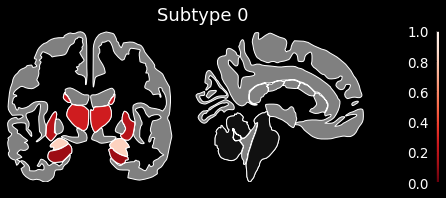

In [77]:
# 4. Plot ASEG
plot_aseg_atlas(T = T, S = S, map_aseg = map_aseg, subtype = 'Subtype 0')  

In [78]:
# plot_dk_atlas(T = T, S = S, map_dk = map_dk, slider = 0.8, save = True, subtype = 'Subtype 0')

# Create animation

In [46]:
def make_gif(frame_folder, subtype, atlas):
    file_list = glob.glob(f'{frame_folder}/*.png')
    file_list.sort()
    frames = [Image.open(image) for image in file_list]
    frame_one = frames[0]
    frame_one.save(f"temp_folder/2D_animations/{atlas}-{subtype}.gif", format="GIF", append_images=frames,
               save_all=True, duration=200, loop=0) 

In [47]:
subtype = 'Subtype 3'
video_slider = np.linspace(0,1,50)
filename = f'{subtype}-{video_slider[0]}'
filename

'Subtype 3-0.0'

In [79]:
def generate_animations(labels):
    
    video_slider = np.linspace(0,1,50)

    for subtype in labels:

        # Clear folder
        directory = 'temp_folder/snapshots'
        filelist = glob.glob(os.path.join(directory, "*"))
        for f in filelist:
            os.remove(f)

        video_slider = np.linspace(0,1,50)

        for value in video_slider:
            filename = f"DK-{subtype}-{value}"

            plot_dk_atlas(T = T, S = S, map_dk = map_dk, 
                          subtype = subtype, 
                          slider=value,
                          save=True, 
                          filename=filename)

        make_gif("temp_folder/snapshots", subtype,'DK')

        # Clear folder
        directory = 'temp_folder/snapshots'
        filelist = glob.glob(os.path.join(directory, "*"))
        for f in filelist:
            os.remove(f)

        for value in video_slider:
            filename = f"ASEG-{subtype}-{value}"

            plot_aseg_atlas(T = T, S = S, map_aseg = map_aseg, 
                          subtype = subtype, 
                          slider=value,
                          save=True, 
                          filename=filename)  # , save=True

        make_gif("temp_folder/snapshots", subtype,'ASEG')

        print(f'PROGRESS: animations for {subtype} SUCCESSFULLY saved to folder: temp_folder/2D_animations')


PROGRESS: animations for Subtype 0 SUCCESSFULLY saved to folder: temp_folder/2D_animations



KeyboardInterrupt



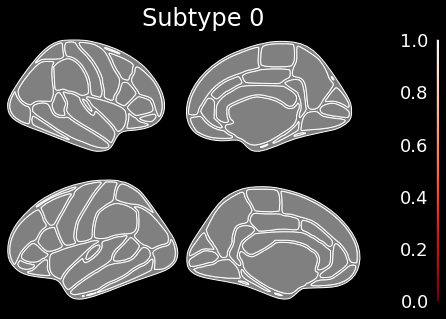

In [60]:
generate_animations(labels)